In [17]:
import pandas as pd
import psycopg
import credentials
import matplotlib.pyplot as plt
import geopandas as gpd
from IPython.display import display, Markdown

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
def connect_to_database():
    """
    Connect to the PostgreSQL database.

    Returns:
        A tuple containing the connection and cursor objects.
    """
    conn = psycopg.connect(
        host="pinniped.postgres.database.azure.com",
        dbname=credentials.DB_USER,
        user=credentials.DB_USER,
        password=credentials.DB_PASSWORD
    )
    cur = conn.cursor()
    return conn, cur
;

In [68]:
#parameters cell.
year = 2021

In [70]:
title = f"Education Report for Academic Year {year}"
display(Markdown(f"# {title}"))
;

# Education Report for Academic Year 2021

''

Question 1: 
Summaries of how many colleges and universities are included in the data for the selected year, by state and type of institution (private, public, for-profit, and so on).

In [33]:
def summarize_colleges_by_state_and_type(year):
    """
    Retrieves the summary of how many colleges and universities are included in the data for the selected year,
    grouped by state and type of institution.

    Args:
        year (int): The selected year for which the data is retrieved.

    Returns:
        pandas.DataFrame: A DataFrame containing the summary information, with columns 'region', 'control', and 'count'.
                          'region' represents the state, 'control' represents the type of institution, and 'count' represents
                          the number of colleges/universities in that state and institution type.
    """
    # Connect to the database
    conn, cur = connect_to_database()

    # Query the data for the selected year
    query = f"SELECT region, control,  COUNT(*) as count FROM institutioninformation WHERE year = {year} GROUP BY region, control ORDER BY region, control;"
    cur.execute(query)
    rows = cur.fetchall()

    # Create a DataFrame from the query results
    df = pd.DataFrame(rows, columns=['region', 'control', 'count'])

    # Map region codes to region names
    region_names = {
        0: 'U.S. Service schools',
        1: 'New England',
        2: 'Mid East',
        3: 'Great Lakes',
        4: 'Plains',
        5: 'Southeast',
        6: 'Southwest',
        7: 'Rocky Mountains',
        8: 'Far West',
        9: 'Outlying areas'
    }

    control_names = {
        1: 'Public',
        2: 'Private nonprofit',
        3: 'Private for-profit'
    }

    df['region'] = df['region'].map(region_names)
    df['control'] = df['control'].map(control_names)

    # Sort by descending tuition rate
    df = df.sort_values(by='count', ascending=False)

    # Close the database connection
    cur.close()
    conn.close()

    return df
;

In [35]:
print('Colleges by State and Type')
res = summarize_colleges_by_state_and_type(year)
res.style.format(precision=0, thousands=",", decimal=".") \
  .format_index(str.upper, axis=1) \
  .relabel_index(["" for x in res.index], axis=0)

Colleges by State and Type


,REGION,CONTROL,COUNT
,Southeast,Private for-profit,550
,Southeast,Public,453
,Far West,Private for-profit,367
,Southeast,Private nonprofit,353
,Mid East,Private nonprofit,322
,Mid East,Private for-profit,310
,Great Lakes,Private for-profit,294
,Southwest,Private for-profit,289
,Great Lakes,Private nonprofit,260
,Great Lakes,Public,251


In [21]:
def summarize_tuition_rates_by_state_and_classification(year):
    """
    Retrieves the summary of current college tuition rates, grouped by state and Carnegie Classification of institution.

    Args:
        year (int): The selected year for which the data is retrieved.

    Returns:
        pandas.DataFrame: A DataFrame containing the summary information, with columns 'region', 'classification', and 'tuition_rate'.
                          'region' represents the state, 'classification' represents the Carnegie Classification of institution,
                          and 'tuition_rate' represents the current tuition rate for that state and classification.
    """
    # Connect to the database
    conn, cur = connect_to_database()

    # Query the data for the selected year
    query = f"SELECT region, ccbasic, AVG(tuitfte) AS avg_tuition FROM institutioninformation NATURAL JOIN studentbody WHERE year = {year} GROUP BY region, ccbasic ORDER BY region;"
    cur.execute(query)
    rows = cur.fetchall()

    # Create a DataFrame from the query results
    df = pd.DataFrame(rows, columns=['region', 'classification', 'tuition_rate'])

    # Map region codes to region names
    region_names = {
        0: 'U.S. Service schools',
        1: 'New England',
        2: 'Mid East',
        3: 'Great Lakes',
        4: 'Plains',
        5: 'Southeast',
        6: 'Southwest',
        7: 'Rocky Mountains',
        8: 'Far West',
        9: 'Outlying areas'
    }

    classification_names = {
        0: 'Not classified',
        1: 'Associates Colleges: High Transfer-High Traditional',
        2: 'Traditional/Nontraditional',
        3: 'Associate\'s Colleges: High Transfer-High Nontraditional',
        4: 'Associate\'s Colleges: Mixed Transfer/Career & Technical-High Traditional',
        5: 'Associate\'s Colleges: Mixed Transfer/Career & Technical-Mixed Traditional/Nontraditional',
        6: 'Associate\'s Colleges: Mixed Transfer/Career & Technical-High Nontraditional',
        7: 'Associate\'s Colleges: High Career & Technical-High Traditional',
        8: 'Associate\'s Colleges: High Career & Technical-Mixed Traditional/Nontraditional',
        9: 'Associate\'s Colleges: High Career & Technical-High Nontraditional',
        10: 'Special Focus Two-Year: Health Professions',
        11: 'Special Focus Two-Year: Technical Professions',
        12: 'Special Focus Two-Year: Arts & Design',
        13: 'Special Focus Two-Year: Other Fields',
        14: 'Baccalaureate/Associate\'s Colleges: Associate\'s Dominant',
        15: 'Doctoral Universities: Very High Research Activity',
        16: 'Doctoral Universities: High Research Activity',
        17: 'Doctoral/Professional Universities',
        18: 'Master\'s Colleges & Universities: Larger Programs',
        19: 'Master\'s Colleges & Universities: Medium Programs',
        20: 'Master\'s Colleges & Universities: Small Programs',
        21: 'Baccalaureate Colleges: Arts & Sciences Focus',
        22: 'Baccalaureate Colleges: Diverse Fields',
        23: 'Baccalaureate/Associate\'s Colleges: Mixed Baccalaureate/Associate\'s',
        24: 'Special Focus Four-Year: Faith-Related Institutions',
        25: 'Special Focus Four-Year: Medical Schools & Centers',
        26: 'Special Focus Four-Year: Other Health Professions Schools',
        27: 'Special Focus Four-Year: Research Schools',
        28: 'Special Focus Four-Year: Engineering and Other Technology-Related Schools',
        29: 'Special Focus Four-Year: Business & Management Schools',
        30: 'Special Focus Four-Year: Arts, Music & Design Schools',
        31: 'Special Focus Four-Year: Law Schools',
        32: 'Special Focus Four-Year: Other Special Focus Institutions',
        33: 'Tribal Colleges'
    }

    df['region'] = df['region'].map(region_names)
    df['classification'] = df['classification'].map(classification_names)

    # Sort by descending tuition rate
    df = df.sort_values(by='tuition_rate', ascending=False)
    df['tuition_rate'] = df['tuition_rate'].astype(float)
    df['tuition_rate'] = df['tuition_rate'].round(2)

    # Close the database connection
    cur.close()
    conn.close()

    return df
;

Tuition Rates by State and Classification


,region,classification,tuition_rate
147,Southeast,Special Focus Four-Year: Business & Management...,65037.00
226,Far West,Special Focus Two-Year: Other Fields,44799.50
24,New England,Master's Colleges & Universities: Larger Programs,40087.91
71,Great Lakes,Special Focus Four-Year: Medical Schools & Cen...,39595.40
31,New England,Special Focus Four-Year: Business & Management...,36385.00
...,...,...,...
172,Southwest,Special Focus Two-Year: Technical Professions,1465.20
216,Far West,Associate's Colleges: Mixed Transfer/Career & ...,1352.83
239,Far West,Associate's Colleges: High Career & Technical-...,1053.32
204,Rocky Mountains,Tribal Colleges,1030.00


In [36]:
print('Tuition Rates by State and Classification')
res = summarize_tuition_rates_by_state_and_classification(year)
res.style.format(precision=0, thousands=",", decimal=".") \
  .format_index(str.upper, axis=1) \
  .relabel_index(["" for x in res.index], axis=0)

Tuition Rates by State and Classification


,REGION,CLASSIFICATION,TUITION_RATE
,Southeast,Special Focus Four-Year: Business & Management Schools,"65,037"
,Far West,Special Focus Two-Year: Other Fields,"44,800"
,New England,Master's Colleges & Universities: Larger Programs,"40,088"
,Great Lakes,Special Focus Four-Year: Medical Schools & Centers,"39,595"
,New England,Special Focus Four-Year: Business & Management Schools,"36,385"
,Far West,Special Focus Four-Year: Medical Schools & Centers,"33,499"
,Southeast,Special Focus Four-Year: Medical Schools & Centers,"32,296"
,Far West,Special Focus Four-Year: Law Schools,"32,097"
,Outlying areas,Special Focus Two-Year: Other Fields,"31,198"
,Mid East,Special Focus Four-Year: Medical Schools & Centers,"30,940"


Question 2:
Summaries of current college tuition rates, by state and Carnegie Classification of institution.

In [22]:
def summarize_tuition_rates_by_state_and_classification(year):
    """
    Retrieves the summary of current college tuition rates, grouped by state and Carnegie Classification of institution.

    Args:
        year (int): The selected year for which the data is retrieved.

    Returns:
        pandas.DataFrame: A DataFrame containing the summary information, with columns 'region', 'classification', and 'tuition_rate'.
                          'region' represents the state, 'classification' represents the Carnegie Classification of institution,
                          and 'tuition_rate' represents the current tuition rate for that state and classification.
    """
    # Connect to the database
    conn, cur = connect_to_database()

    # Query the data for the selected year
    query = f"SELECT region, ccbasic, AVG(tuitfte) AS avg_tuition FROM institutioninformation NATURAL JOIN studentbody WHERE year = {year} GROUP BY region, ccbasic ORDER BY region;"
    cur.execute(query)
    rows = cur.fetchall()

    # Create a DataFrame from the query results
    df = pd.DataFrame(rows, columns=['region', 'classification', 'tuition_rate'])

    # Map region codes to region names
    region_names = {
        0: 'U.S. Service schools',
        1: 'New England',
        2: 'Mid East',
        3: 'Great Lakes',
        4: 'Plains',
        5: 'Southeast',
        6: 'Southwest',
        7: 'Rocky Mountains',
        8: 'Far West',
        9: 'Outlying areas'
    }

    classification_names = {
        0: 'Not classified',
        1: 'Associates Colleges: High Transfer-High Traditional',
        2: 'Traditional/Nontraditional',
        3: 'Associate\'s Colleges: High Transfer-High Nontraditional',
        4: 'Associate\'s Colleges: Mixed Transfer/Career & Technical-High Traditional',
        5: 'Associate\'s Colleges: Mixed Transfer/Career & Technical-Mixed Traditional/Nontraditional',
        6: 'Associate\'s Colleges: Mixed Transfer/Career & Technical-High Nontraditional',
        7: 'Associate\'s Colleges: High Career & Technical-High Traditional',
        8: 'Associate\'s Colleges: High Career & Technical-Mixed Traditional/Nontraditional',
        9: 'Associate\'s Colleges: High Career & Technical-High Nontraditional',
        10: 'Special Focus Two-Year: Health Professions',
        11: 'Special Focus Two-Year: Technical Professions',
        12: 'Special Focus Two-Year: Arts & Design',
        13: 'Special Focus Two-Year: Other Fields',
        14: 'Baccalaureate/Associate\'s Colleges: Associate\'s Dominant',
        15: 'Doctoral Universities: Very High Research Activity',
        16: 'Doctoral Universities: High Research Activity',
        17: 'Doctoral/Professional Universities',
        18: 'Master\'s Colleges & Universities: Larger Programs',
        19: 'Master\'s Colleges & Universities: Medium Programs',
        20: 'Master\'s Colleges & Universities: Small Programs',
        21: 'Baccalaureate Colleges: Arts & Sciences Focus',
        22: 'Baccalaureate Colleges: Diverse Fields',
        23: 'Baccalaureate/Associate\'s Colleges: Mixed Baccalaureate/Associate\'s',
        24: 'Special Focus Four-Year: Faith-Related Institutions',
        25: 'Special Focus Four-Year: Medical Schools & Centers',
        26: 'Special Focus Four-Year: Other Health Professions Schools',
        27: 'Special Focus Four-Year: Research Schools',
        28: 'Special Focus Four-Year: Engineering and Other Technology-Related Schools',
        29: 'Special Focus Four-Year: Business & Management Schools',
        30: 'Special Focus Four-Year: Arts, Music & Design Schools',
        31: 'Special Focus Four-Year: Law Schools',
        32: 'Special Focus Four-Year: Other Special Focus Institutions',
        33: 'Tribal Colleges'
    }

    df['region'] = df['region'].map(region_names)
    df['classification'] = df['classification'].map(classification_names)

    # Sort by descending tuition rate
    df = df.sort_values(by='tuition_rate', ascending=False)
    df['tuition_rate'] = df['tuition_rate'].astype(float)
    df['tuition_rate'] = df['tuition_rate'].round(2)

    # Close the database connection
    cur.close()
    conn.close()

    return df
;

tuition rates by state and classification


,region,classification,tuition_rate
147,Southeast,Special Focus Four-Year: Business & Management...,65037.00
226,Far West,Special Focus Two-Year: Other Fields,44799.50
24,New England,Master's Colleges & Universities: Larger Programs,40087.91
71,Great Lakes,Special Focus Four-Year: Medical Schools & Cen...,39595.40
31,New England,Special Focus Four-Year: Business & Management...,36385.00
...,...,...,...
172,Southwest,Special Focus Two-Year: Technical Professions,1465.20
216,Far West,Associate's Colleges: Mixed Transfer/Career & ...,1352.83
239,Far West,Associate's Colleges: High Career & Technical-...,1053.32
204,Rocky Mountains,Tribal Colleges,1030.00


In [37]:
print('tuition rates by state and classification')
res = summarize_tuition_rates_by_state_and_classification(year)
res.style.format(precision=0, thousands=",", decimal=".") \
  .format_index(str.upper, axis=1) \
  .relabel_index(["" for x in res.index], axis=0)

tuition rates by state and classification


,REGION,CLASSIFICATION,TUITION_RATE
,Southeast,Special Focus Four-Year: Business & Management Schools,"65,037"
,Far West,Special Focus Two-Year: Other Fields,"44,800"
,New England,Master's Colleges & Universities: Larger Programs,"40,088"
,Great Lakes,Special Focus Four-Year: Medical Schools & Centers,"39,595"
,New England,Special Focus Four-Year: Business & Management Schools,"36,385"
,Far West,Special Focus Four-Year: Medical Schools & Centers,"33,499"
,Southeast,Special Focus Four-Year: Medical Schools & Centers,"32,296"
,Far West,Special Focus Four-Year: Law Schools,"32,097"
,Outlying areas,Special Focus Two-Year: Other Fields,"31,198"
,Mid East,Special Focus Four-Year: Medical Schools & Centers,"30,940"


In [23]:
def summarize_tuition_rates_by_state(year):
    """
    Retrieves the summary of current college tuition rates, grouped by state of institution.

    Args:
        year (int): The selected year for which the data is retrieved.

    Returns:
        pandas.DataFrame: A DataFrame containing the summary information, with columns 'region', and 'tuition_rate'.
                          'region' represents the state, 'classification' 
                          and 'tuition_rate' represents the current tuition rate for that state and classification.
    """
    # Connect to the database
    conn, cur = connect_to_database()

    # Query the data for the selected year
    query = f"SELECT region, AVG(tuitfte) AS avg_tuition FROM institutioninformation NATURAL JOIN studentbody WHERE year = {year} GROUP BY region ORDER BY region;"
    cur.execute(query)
    rows = cur.fetchall()

    # Create a DataFrame from the query results
    df = pd.DataFrame(rows, columns=['region', 'tuition_rate'])

    # Map region codes to region names
    region_names = {
        0: 'U.S. Service schools',
        1: 'New England',
        2: 'Mid East',
        3: 'Great Lakes',
        4: 'Plains',
        5: 'Southeast',
        6: 'Southwest',
        7: 'Rocky Mountains',
        8: 'Far West',
        9: 'Outlying areas'
    }

    df['region'] = df['region'].map(region_names)

    df['tuition_rate'] = df['tuition_rate'].astype(float)
    df['tuition_rate'] = df['tuition_rate'].round(2)

    # Sort by descending tuition rate
    df = df.sort_values(by='tuition_rate', ascending=False)

    # Close the database connection
    cur.close()
    conn.close()

    return df
;

tuition rates by state


,region,tuition_rate
1,New England,17993.00
2,Mid East,13381.72
8,Far West,12515.89
3,Great Lakes,11294.75
4,Plains,9996.65
5,Southeast,9894.30
7,Rocky Mountains,9892.97
6,Southwest,9534.03
9,Outlying areas,6988.88
0,U.S. Service schools,0.00


In [38]:
print('tuition rates by state')
res = summarize_tuition_rates_by_state(year)
res.style.format(precision=0, thousands=",", decimal=".") \
  .format_index(str.upper, axis=1) \
  .relabel_index(["" for x in res.index], axis=0)

tuition rates by state


,REGION,TUITION_RATE
,New England,"17,993"
,Mid East,"13,382"
,Far West,"12,516"
,Great Lakes,"11,295"
,Plains,"9,997"
,Southeast,"9,894"
,Rocky Mountains,"9,893"
,Southwest,"9,534"
,Outlying areas,"6,989"
,U.S. Service schools,0


In [24]:
def summarize_tuition_rates_by_classification(year):
    """
    Retrieves the summary of current college tuition rates, grouped by Carnegie Classification of institution.

    Args:
        year (int): The selected year for which the data is retrieved.

    Returns:
        pandas.DataFrame: A DataFrame containing the summary information, with columns 'classification', and 'tuition_rate'.
                          'classification' represents the Carnegie Classification of institution,
                          and 'tuition_rate' represents the current tuition rate for that classification.
    """
    # Connect to the database
    conn, cur = connect_to_database()

    # Query the data for the selected year
    query = f"SELECT ccbasic, AVG(tuitfte) AS avg_tuition FROM institutioninformation NATURAL JOIN studentbody WHERE year = {year} GROUP BY ccbasic ORDER BY ccbasic;"
    cur.execute(query)
    rows = cur.fetchall()

    # Create a DataFrame from the query results
    df = pd.DataFrame(rows, columns=['classification', 'tuition_rate'])

    # Map region codes to classification names
    classification_names = {
        0: 'Not classified',
        1: 'Associates Colleges: High Transfer-High Traditional',
        2: 'Traditional/Nontraditional',
        3: 'Associate\'s Colleges: High Transfer-High Nontraditional',
        4: 'Associate\'s Colleges: Mixed Transfer/Career & Technical-High Traditional',
        5: 'Associate\'s Colleges: Mixed Transfer/Career & Technical-Mixed Traditional/Nontraditional',
        6: 'Associate\'s Colleges: Mixed Transfer/Career & Technical-High Nontraditional',
        7: 'Associate\'s Colleges: High Career & Technical-High Traditional',
        8: 'Associate\'s Colleges: High Career & Technical-Mixed Traditional/Nontraditional',
        9: 'Associate\'s Colleges: High Career & Technical-High Nontraditional',
        10: 'Special Focus Two-Year: Health Professions',
        11: 'Special Focus Two-Year: Technical Professions',
        12: 'Special Focus Two-Year: Arts & Design',
        13: 'Special Focus Two-Year: Other Fields',
        14: 'Baccalaureate/Associate\'s Colleges: Associate\'s Dominant',
        15: 'Doctoral Universities: Very High Research Activity',
        16: 'Doctoral Universities: High Research Activity',
        17: 'Doctoral/Professional Universities',
        18: 'Master\'s Colleges & Universities: Larger Programs',
        19: 'Master\'s Colleges & Universities: Medium Programs',
        20: 'Master\'s Colleges & Universities: Small Programs',
        21: 'Baccalaureate Colleges: Arts & Sciences Focus',
        22: 'Baccalaureate Colleges: Diverse Fields',
        23: 'Baccalaureate/Associate\'s Colleges: Mixed Baccalaureate/Associate\'s',
        24: 'Special Focus Four-Year: Faith-Related Institutions',
        25: 'Special Focus Four-Year: Medical Schools & Centers',
        26: 'Special Focus Four-Year: Other Health Professions Schools',
        27: 'Special Focus Four-Year: Research Schools',
        28: 'Special Focus Four-Year: Engineering and Other Technology-Related Schools',
        29: 'Special Focus Four-Year: Business & Management Schools',
        30: 'Special Focus Four-Year: Arts, Music & Design Schools',
        31: 'Special Focus Four-Year: Law Schools',
        32: 'Special Focus Four-Year: Other Special Focus Institutions',
        33: 'Tribal Colleges'
    }

    df['classification'] = df['classification'].map(classification_names)

    df['tuition_rate'] = df['tuition_rate'].astype(float)

    df['tuition_rate'] = df['tuition_rate'].round(2)

    # Sort by descending tuition rate
    df = df.sort_values(by='tuition_rate', ascending=False)

    # Close the database connection
    cur.close()
    conn.close()

    return df
;

Tuition Rates by Classification


,classification,tuition_rate
25,Special Focus Four-Year: Medical Schools & Cen...,28587.51
30,"Special Focus Four-Year: Arts, Music & Design ...",25350.79
31,Special Focus Four-Year: Law Schools,24357.62
13,Special Focus Two-Year: Other Fields,24313.85
32,Special Focus Four-Year: Other Special Focus I...,21035.71
29,Special Focus Four-Year: Business & Management...,21004.94
26,Special Focus Four-Year: Other Health Professi...,20475.29
15,Doctoral Universities: Very High Research Acti...,19185.73
14,Baccalaureate/Associate's Colleges: Associate'...,18023.40
21,Baccalaureate Colleges: Arts & Sciences Focus,17834.12


In [39]:
print('Tuition Rates by Classification')
res = summarize_tuition_rates_by_classification(year)
res.style.format(precision=0, thousands=",", decimal=".") \
  .format_index(str.upper, axis=1) \
  .relabel_index(["" for x in res.index], axis=0)

Tuition Rates by Classification


,CLASSIFICATION,TUITION_RATE
,Special Focus Four-Year: Medical Schools & Centers,"28,588"
,"Special Focus Four-Year: Arts, Music & Design Schools","25,351"
,Special Focus Four-Year: Law Schools,"24,358"
,Special Focus Two-Year: Other Fields,"24,314"
,Special Focus Four-Year: Other Special Focus Institutions,"21,036"
,Special Focus Four-Year: Business & Management Schools,"21,005"
,Special Focus Four-Year: Other Health Professions Schools,"20,475"
,Doctoral Universities: Very High Research Activity,"19,186"
,Baccalaureate/Associate's Colleges: Associate's Dominant,"18,023"
,Baccalaureate Colleges: Arts & Sciences Focus,"17,834"


Question 3: 
A table showing the best- and worst-performing institutions by loan repayment rates.

In [40]:
def get_best_and_worst_performing_institutions_by_loan_repayment_rates(year):
    # Connect to the database
    conn, cur = connect_to_database()

    # Query the data for the selected year
    query = f"SELECT * FROM loanrepayments WHERE year = {year};"

    cur.execute(query)
    rows = cur.fetchall()

    # Create a DataFrame from the query results
    df = pd.DataFrame(rows, columns=[
        'unitid',
        'year',
        'dbrr1_fed_ug_n',
        'dbrr1_fed_ug_rt',
        'dbrr4_fed_ug_n',
        'dbrr4_fed_ug_rt',
        'dbrr5_fed_ug_n',
        'dbrr5_fed_ug_rt',
        'dbrr10_fed_ug_n',
        'dbrr10_fed_ug_rt',
        'dbrr20_fed_ug_n',
        'dbrr20_fed_ug_rt'
        ])

    # Join the institutioninformation table to get the institution name (instnm)
    institution_query = f"SELECT unitid, instnm FROM institutioninformation WHERE year = {year};"
    cur.execute(institution_query)
    institution_rows = cur.fetchall()
    institution_df = pd.DataFrame(institution_rows, columns=['unitid', 'instnm'])

    # Calculate scaled values for each loan repayment column
    for column in df.columns[2:]:
        min_value = df[column].min()
        max_value = df[df[column] != 999][column].max()  # Filter out values equal to 999
        df[column] = (df[column] - min_value) / (max_value - min_value)

    # Calculate the average scaled value for each institution
    df['avg_scaled_value'] = df.iloc[:, 2:].mean(axis=1)

    # Filter out institutions with values > 1
    df = df[df['avg_scaled_value'] <= 1]

    # Sort the DataFrame by the average scaled value
    df = df.sort_values(by=['avg_scaled_value'])

    # Merge the institutioninformation DataFrame with the loanrepayments DataFrame
    df = pd.merge(df, institution_df, on='unitid')

    # Keep only the instnm, and average scaled value columns
    df = df[['instnm', 'avg_scaled_value']]

    # Get the top 10 best performing institutions
    best = df.head(10)

    # Get the top 10 worst performing institutions
    worst = df.tail(10)

    # Close the database connection
    cur.close()
    conn.close()

    return best, worst
;

In [54]:
best, worst = get_best_and_worst_performing_institutions_by_loan_repayment_rates(year)
print('Best Performing Institutions by Loan Repayment Rates')
best.style.format(precision=3, thousands=",", decimal=".").format_index(str.upper, axis=1).relabel_index(["" for x in best.index], axis=0).relabel_index(["Institution Name", "Non-repaying students (proportion)"], axis = 1)

Best Performing Institutions by Loan Repayment Rates


,Institution Name,Non-repaying students (proportion)
,California Institute of Technology,0.024
,Harvey Mudd College,0.035
,Massachusetts Institute of Technology,0.074
,Pontifical College Josephinum,0.077
,Rose-Hulman Institute of Technology,0.079
,United States Merchant Marine Academy,0.090
,Whitman College,0.092
,Thomas Aquinas College,0.093
,Webb Institute,0.094
,Dordt University,0.096


In [55]:
print('Worst Performing Institutions by Loan Repayment Rates')
worst.style.format(precision=3, thousands=",", decimal=".").format_index(str.upper, axis=1).relabel_index(["" for x in best.index], axis=0).relabel_index(["Institution Name", "Non-repaying students (proportion)"], axis = 1)

Worst Performing Institutions by Loan Repayment Rates


,Institution Name,Non-repaying students (proportion)
,University of Phoenix-Arizona,0.781
,University of Phoenix-Hawaii,0.781
,University of Phoenix-Florida,0.781
,University of Phoenix-Georgia,0.781
,University of Phoenix-Illinois,0.781
,University of Phoenix-Utah,0.781
,University of Phoenix-Nevada,0.781
,University of Phoenix-Texas,0.781
,University of Phoenix-California,0.781
,University of Phoenix-New Jersey,0.781


Question 4: 
Graphs showing how tuition rates and loan repayment rates have changed over time, either in aggregate (such as averages for all institutions by type) or for selected institutions (such as the most expensive).

In [64]:
def get_yearly_tuition_rates_by_control():
    # Connect to the database
    conn, cur = connect_to_database()

    # Query the data for the selected year
    query = f"SELECT year, control, AVG(tuitfte) AS avg_tuition FROM institutioninformation NATURAL JOIN studentbody GROUP BY year, control ORDER BY year;"
    cur.execute(query)
    rows = cur.fetchall()

    # Create a DataFrame from the query results
    df = pd.DataFrame(rows, columns=['year', 'control', 'avg_tuition'])

    df['year'] = pd.to_datetime(df['year'], format='%Y')

    control_names = {
        1: 'Public',
        2: 'Private nonprofit',
        3: 'Private for-profit'
    }

    df['control'] = df['control'].map(control_names)

    # Plotting
    fig, ax = plt.subplots()
    for control, data in df.groupby('control'):
        ax.plot(data['year'], data['avg_tuition'], label=control)

    ax.set_title('Yearly Tuition Rates by Control')
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Tuition')
    ax.legend(loc='center left')
    plt.xticks(rotation=45)
    plt.show()

    # Close the database connection
    cur.close()
    conn.close()
;

''

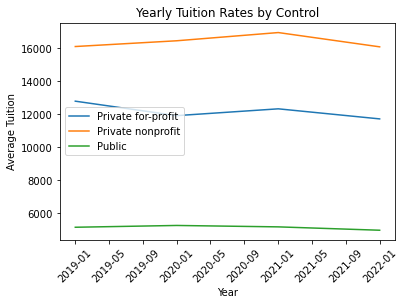

In [65]:
get_yearly_tuition_rates_by_control()

Question 5: A map of the united states showing the tuition rate by region.

In [66]:
def plot_map_tuitionrate_region(year):
    # Connect to the database
    conn, cur = connect_to_database()

    # Query the data for the selected year
    query = f"SELECT region, AVG(tuitfte) AS avg_tuition FROM institutioninformation NATURAL JOIN studentbody WHERE year = {year} GROUP BY region ORDER BY region;"
    cur.execute(query)
    rows = cur.fetchall()

    # Create a DataFrame from the query results
    df = pd.DataFrame(rows, columns=['region', 'avg_tuition'])

    # Map region codes to region names
    region_names = {
        0: 'U.S. Service schools',
        1: 'Northeast',
        2: 'Northeast',
        3: 'Midwest',
        4: 'Midwest',
        5: 'Southeast',
        6: 'Southwest',
        7: 'West',
        8: 'West',
        9: 'Outlying areas'
    }

    df['region'] = df['region'].map(region_names)

    states = gpd.read_file('usa-states-census-2014.shp')

    # Merge the GeoDataFrame with the DataFrame containing the average tuition rates
    merged = states.merge(df, left_on='region', right_on='region')

    # Plotting
    fig, ax = plt.subplots()
    merged.plot(column='avg_tuition', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.axis('off')
    ax.set_title('Average Tuition Rates by Region')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=merged['avg_tuition'].min(), vmax=merged['avg_tuition'].max()))
    sm._A = []
    cbar = fig.colorbar(sm)
    plt.show()

    # Close the database connection
    cur.close()
    conn.close()   
;

''

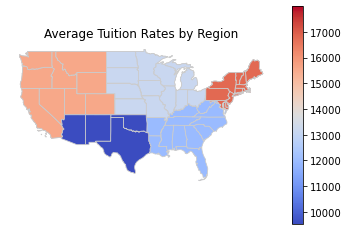

In [67]:
plot_map_tuitionrate_region(year)

Question 6: Plotting average tuition against the number of loans and faculty salaries. 

In [59]:
def plot_tuition_loans_faculty(year):
    
    conn, cur = connect_to_database()

    # Query the data for the selected year
    query1 = f"SELECT unitid, year, tuitfte, avgfacsal FROM institutioninformation NATURAL JOIN studentbody WHERE year = {year};"
    cur.execute(query1)
    rows = cur.fetchall()

    # Create a DataFrame from the query results
    tf = pd.DataFrame(rows, columns=['unitid', 'year', 'tuitfte', 'avgfacsal'])

    query2 = f"SELECT * FROM loanrepayments WHERE year = {year};"

    cur.execute(query2)
    rows = cur.fetchall()

    # Create a DataFrame from the query results
    lr = pd.DataFrame(rows, columns=[
        'unitid',
        'year',
        'dbrr1_fed_ug_n',
        'dbrr1_fed_ug_rt',
        'dbrr4_fed_ug_n',
        'dbrr4_fed_ug_rt',
        'dbrr5_fed_ug_n',
        'dbrr5_fed_ug_rt',
        'dbrr10_fed_ug_n',
        'dbrr10_fed_ug_rt',
        'dbrr20_fed_ug_n',
        'dbrr20_fed_ug_rt'
        ])

    # Calculate scaled values for each loan repayment column
    for column in lr.columns[2:]:
        min_value = lr[column].min()
        max_value = lr[lr[column] != 999][column].max()  # Filter out values equal to 999
        lr[column] = (lr[column] - min_value) / (max_value - min_value)

    # Calculate the average scaled value for each institution
    lr['avg_scaled_value'] = lr.iloc[:, 2:].mean(axis=1)

    # Filter out institutions with values > 1
    lr = lr[lr['avg_scaled_value'] <= 1]

    lr = lr.loc[:, ['unitid', 'year', 'avg_scaled_value']]

    merged_df = tf.merge(lr, on=['unitid', 'year'])

    # Scatter plot of tuition vs. loan repayment rates
    plt.scatter(merged_df['tuitfte'], merged_df['avg_scaled_value'])
    plt.title('Tuition vs. Loan Repayment Rates')
    plt.xlabel('Average Tuition')
    plt.ylabel('Average Loan Repayment Rate')
    plt.show()

    # Scatter plot of faculty salaries vs. loan repayment rates
    plt.scatter(merged_df['avgfacsal'], merged_df['avg_scaled_value'])
    plt.title('Faculty Salaries vs. Loan Repayment Rates')
    plt.xlabel('Average Faculty Salary')
    plt.ylabel('Average Loan Repayment Rate')
    plt.show()

    # Scatter plot of faculty salaries vs. tuition
    plt.scatter(merged_df['avgfacsal'], merged_df['tuitfte'])
    plt.title('Faculty Salaries vs. Loan Repayment Rates')
    plt.xlabel('Average Faculty Salary')
    plt.ylabel('Average Loan Repayment Rate')
    plt.show()

    # Close the database connection
    cur.close()
    conn.close()

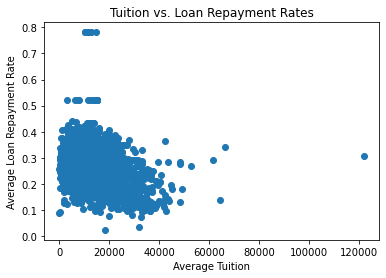

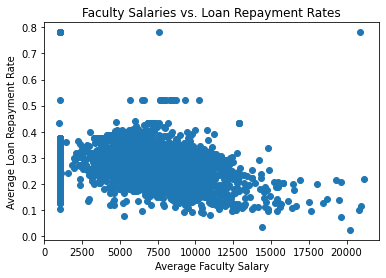

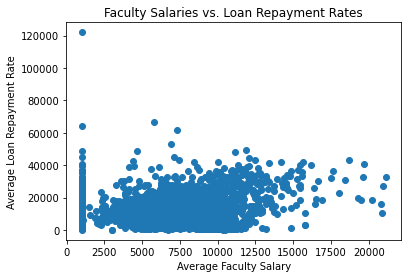

In [60]:
plot_tuition_loans_faculty(year)

Question 7: A table of institutions that did not report data in the selected year but did previously, or that are new this year.

In [63]:
def institution_new(year):
    conn, cur = connect_to_database()
    
    sql_query = f"""
    SELECT i.unitid, i.instnm
    FROM institutioninformation i
    WHERE i.year = {year}
    AND i.unitid NOT IN (
        SELECT unitid FROM institutioninformation WHERE year IN ({', '.join(map(str, range(2019, year)))})
    )
    """
    
    cur.execute(sql_query)
    query_results = cur.fetchall()
    df = pd.DataFrame(query_results, columns=['Unit id', 'institution name'])
    
    cur.close()
    conn.close()

    title = f"The New Institution for Year {year}"
    display(Markdown(f"# {title}"))
    return df
    #print(df)


res = institution_new(year)
res

# The New Institution for Year 2021

,Unit id,institution name
0,105349,Northland Pioneer College
1,122694,San Joaquin Valley College-Bakersfield
2,125082,Bridges Beauty College
3,134422,Key College
4,148885,University of Saint Mary of the Lake
...,...,...
96,496265,Triangle Tech-Chambersburg
97,496283,Provo College-Idaho Falls Campus
98,496292,Miller-Motte College-Chattanooga 2
99,496326,Eagle Gate College-Boise Campus
